# GAIN Code

In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn
import torch.utils.data
import torch.optim as optim

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

print(torch.__version__)

1.7.0


## Utility functions for GAIN.

1. normalization: MinMax Normalizer
1. renormalization: Recover the data from normalzied data
1. rounding: Handlecategorical variables after imputation
1. rmse_loss: Evaluate imputed data in terms of RMSE
1. xavier_init: Xavier initialization
1. binary_sampler: sample binary random variables
1. uniform_sampler: sample uniform random variables
1. sample_batch_index: sample random batch index

In [2]:
def normalization (data):
  '''Normalize data in [0, 1] range.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  '''

  # Parameters
  _, dim = data.shape
  norm_data = data.copy()
  
  # MixMax normalization
  min_val = np.zeros(dim)
  max_val = np.zeros(dim)
  
  # For each dimension
  for i in range(dim):
    min_val[i] = np.nanmin(norm_data[:,i])
    norm_data[:,i] = norm_data[:,i] - np.nanmin(norm_data[:,i])
    max_val[i] = np.nanmax(norm_data[:,i])
    norm_data[:,i] = norm_data[:,i] / (np.nanmax(norm_data[:,i]) + 1e-6)   
    
  # Return norm_parameters for renormalization
  norm_parameters = {'min_val': min_val,
                     'max_val': max_val}
      
  return norm_data, norm_parameters

def renormalization (norm_data, norm_parameters):
  '''Renormalize data from [0, 1] range to the original range.
  
  Args:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  
  Returns:
    - renorm_data: renormalized original data
  '''
  
  min_val = norm_parameters['min_val']
  max_val = norm_parameters['max_val']

  _, dim = norm_data.shape
  renorm_data = norm_data.copy()
    
  for i in range(dim):
    renorm_data[:,i] = renorm_data[:,i] * (max_val[i] + 1e-6)   
    renorm_data[:,i] = renorm_data[:,i] + min_val[i]
    
  return renorm_data

def rounding (imputed_data, data_x):
  '''Round imputed data for categorical variables.
  
  Args:
    - imputed_data: imputed data
    - data_x: original data with missing values
    
  Returns:
    - rounded_data: rounded imputed data
  '''
  
  _, dim = data_x.shape
  rounded_data = imputed_data.copy()
  
  for i in range(dim):
    temp = data_x[~np.isnan(data_x[:, i]), i]
    # Only for the categorical variable
    if len(np.unique(temp)) < 20:
      rounded_data[:, i] = np.round(rounded_data[:, i])
      
  return rounded_data

def rmse_loss (ori_data, imputed_data, data_m):
  '''Compute RMSE loss between ori_data and imputed_data
  
  Args:
    - ori_data: original data without missing values
    - imputed_data: imputed data
    - data_m: indicator matrix for missingness
    
  Returns:
    - rmse: Root Mean Squared Error
  '''
  
  ori_data, _ = normalization(ori_data)
  imputed_data, _ = normalization(imputed_data)
    
  # Only for missing values
  nominator = np.sum(((1-data_m) * ori_data - (1-data_m) * imputed_data)**2)
  denominator = np.sum(1-data_m)
  
  rmse = np.sqrt(nominator/float(denominator))
  
  return rmse

In [3]:
def binary_sampler(p, rows, cols):
  '''Sample binary random variables.
  
  Args:
    - p: probability of 1
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - binary_random_matrix: generated binary random matrix.
  '''
  unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix

def uniform_sampler(low, high, rows, cols):
  '''Sample uniform random variables.
  
  Args:
    - low: low limit
    - high: high limit
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - uniform_random_matrix: generated uniform random matrix.
  '''
  return np.random.uniform(low, high, size = [rows, cols])


def sample_batch_index(total, batch_size):
  '''Sample index of the mini-batch.
  
  Args:
    - total: total number of samples
    - batch_size: batch size
    
  Returns:
    - batch_idx: batch index
  '''
  total_idx = np.random.permutation(total)
  batch_idx = total_idx[:batch_size]
  return batch_idx

## Data

In [4]:
theta = 7
num_epochs = 500

data_path = 'https://raw.githubusercontent.com/kw-lee/MIDA-pytorch/master/data/BostonHousing.csv'
mechanism = 'mcar'
method = 'uniform'

test_size = 0.3
use_cuda = True
batch_size  = 59 # not in the paper

In [5]:
data = pd.read_csv(data_path).values

rows, cols = data.shape
shuffled_index = np.random.permutation(rows)
train_index = shuffled_index[:int(rows*(1-test_size))]
test_index = shuffled_index[int(rows*(1-test_size)):]

train_data = data[train_index, :]
test_data = data[test_index, :]

# standardized between 0 and 1
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [6]:
# def missing_method(raw_data, mechanism='mcar', method='uniform') :
    
#     data = raw_data.copy()
#     rows, cols = data.shape
    
#     # missingness threshold
#     t = 0.2
    
#     if mechanism == 'mcar' :
    
#         if method == 'uniform' :
#             # uniform random vector
#             v = np.random.uniform(size=(rows, cols))

#             # missing values where v<=t
#             mask = (v<=t)
#             data[mask] = 0

#         elif method == 'random' :
#             # only half of the attributes to have missing value
#             missing_cols = np.random.choice(cols, cols//2)
#             c = np.zeros(cols, dtype=bool)
#             c[missing_cols] = True

#             # uniform random vector
#             v = np.random.uniform(size=(rows, cols))

#             # missing values where v<=t
#             mask = (v<=t)*c
#             data[mask] = 0

#         else :
#             print("Error : There are no such method")
#             raise
    
#     elif mechanism == 'mnar' :
        
#         if method == 'uniform' :
#             # randomly sample two attributes
#             sample_cols = np.random.choice(cols, 2)

#             # calculate ther median m1, m2
#             m1, m2 = np.median(data[:,sample_cols], axis=0)
#             # uniform random vector
#             v = np.random.uniform(size=(rows, cols))

#             # missing values where (v<=t) and (x1 <= m1 or x2 >= m2)
#             m1 = data[:,sample_cols[0]] <= m1
#             m2 = data[:,sample_cols[1]] >= m2
#             m = (m1*m2)[:, np.newaxis]

#             mask = m*(v<=t)
#             data[mask] = 0


#         elif method == 'random' :
#             # only half of the attributes to have missing value
#             missing_cols = np.random.choice(cols, cols//2)
#             c = np.zeros(cols, dtype=bool)
#             c[missing_cols] = True

#             # randomly sample two attributes
#             sample_cols = np.random.choice(cols, 2)

#             # calculate ther median m1, m2
#             m1, m2 = np.median(data[:,sample_cols], axis=0)
#             # uniform random vector
#             v = np.random.uniform(size=(rows, cols))

#             # missing values where (v<=t) and (x1 <= m1 or x2 >= m2)
#             m1 = data[:,sample_cols[0]] <= m1
#             m2 = data[:,sample_cols[1]] >= m2
#             m = (m1*m2)[:, np.newaxis]

#             mask = m*(v<=t)*c
#             data[mask] = 0

#         else :
#             print("Error : There is no such method")
#             raise
    
#     else :
#         print("Error : There is no such mechanism")
#         raise
        
#     return data, mask

## Data Loader

In [7]:
'''Data loader for UCI letter, spam and MNIST datasets.
'''


def data_loader (data_x, data_name=None, miss_rate=0.5):
  '''Loads datasets and introduce missingness.
  
  Args:
    - data_name: letter, spam, or mnist
    - miss_rate: the probability of missing components
    
  Returns:
    data_x: original data
    miss_data_x: data with missing values
    data_m: indicator matrix for missing components
  '''
  if data_x is None:
    # Load data
    if data_name in ['letter', 'spam']:
      file_name = 'data/'+data_name+'.csv'
      data_x = np.loadtxt(file_name, delimiter=",", skiprows=1)
    elif data_name == 'mnist':
      (data_x, _), _ = mnist.load_data()
      data_x = np.reshape(np.asarray(data_x), [60000, 28*28]).astype(float)

  # Parameters
  no, dim = data_x.shape
  
  # Introduce missing data
  data_m = binary_sampler(1-miss_rate, no, dim)
  miss_data_x = data_x.copy()
  miss_data_x[data_m == 0] = np.nan
      
  return data_x, miss_data_x, data_m

In [8]:
data_x, miss_data_x, data_m = data_loader(train_data, miss_rate=0.3)

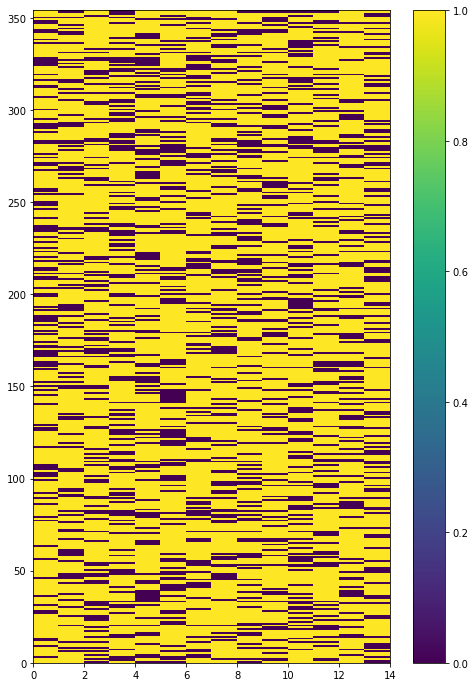

In [9]:
fig = plt.figure(figsize = (8, 12))
plt.pcolormesh(data_m)
plt.colorbar()
plt.show()

In [10]:
# missed_data, mask = missing_method(test_data, mechanism=mechanism, method=method)

# missed_data = torch.from_numpy(missed_data).float()
# train_data = torch.from_numpy(train_data).float()

data_x = torch.from_numpy(data_x).float()
miss_data_x0 = torch.from_numpy(np.nan_to_num(miss_data_x, nan=0.0, copy=True)).float()
data_m = torch.from_numpy(data_m).float()

train_loader = torch.utils.data.DataLoader(dataset=torch.cat([miss_data_x0, data_m], axis=1),
                                           batch_size=batch_size,
                                           shuffle=True)

## Model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
class Generator(nn.Module):
  def __init__(self, dim):
    super(Generator, self).__init__()
    self.dim = dim
    self.body = nn.Sequential(
      nn.Linear(self.dim*2, self.dim),
      nn.ReLU(),
      nn.Linear(self.dim, self.dim),
      nn.ReLU(),
      nn.Linear(self.dim, self.dim),
      nn.Sigmoid()
    )
    
  def forward(self, x):
    return self.body(x)
    
    
class Discriminator(nn.Module):
  def __init__(self, dim):
    super(Discriminator, self).__init__()
    self.dim = dim
    self.body = nn.Sequential(
      nn.Linear(self.dim*2, self.dim),
      nn.ReLU(),
      nn.Linear(self.dim, self.dim),
      nn.ReLU(),
      nn.Linear(self.dim, self.dim),
      nn.Sigmoid()
    )
    
  def forward(self, x):
    return self.body(x)

In [13]:
G = Generator(dim=cols)
D = Discriminator(dim=cols)

G.to(device)
D.to(device)

Discriminator(
  (body): Sequential(
    (0): Linear(in_features=28, out_features=14, bias=True)
    (1): ReLU()
    (2): Linear(in_features=14, out_features=14, bias=True)
    (3): ReLU()
    (4): Linear(in_features=14, out_features=14, bias=True)
    (5): Sigmoid()
  )
)

In [14]:
def sample_z(dim, batch_size=1):
  return torch.rand(batch_size, dim, device=device)*0.01

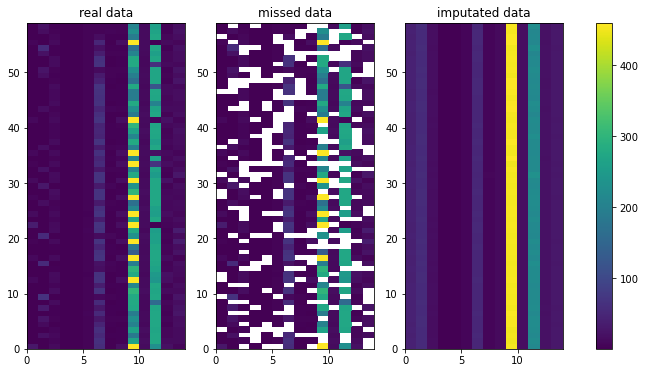

In [15]:
# example
z = sample_z(cols, batch_size)
input_fake = torch.cat([z, data_m[:batch_size, ]], axis=1)
data_fake = G(input_fake)


f, axs = plt.subplots(1,3, figsize=(12,6))
axs[0].pcolormesh(scaler.inverse_transform(data_x[:batch_size]))
axs[0].set_title("real data")
axs[1].pcolormesh(scaler.inverse_transform(miss_data_x[:batch_size]))
axs[1].set_title("missed data")
im = axs[2].pcolormesh(scaler.inverse_transform(data_fake.cpu().detach()))
axs[2].set_title("imputated data")

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

## Training

In [16]:
ALMOSTZERO=1e-8
D_loss = nn.functional.binary_cross_entropy
# def D_loss(M, D_prob):
#   d_loss = -(M * torch.log(D_prob + ALMOSTZERO) + (1-M)*torch.log(1-D_prob+ALMOSTZERO)).mean()
#   return d_loss

def G_loss(X, M, G_sample, D_prob, alpha=100):
  g_loss = -((1-M) * torch.log(D_prob + ALMOSTZERO)).mean() + \
    alpha * ((M*X-M*G_sample)**2).mean() / M.mean()
  return g_loss

In [17]:
G_optimizer = optim.Adam(G.parameters())
D_optimizer = optim.Adam(D.parameters())

In [18]:
G_loss_list = []
D_loss_list = []
early_stop = False
num_epochs = 2000
hint_rate = 0.9
alpha = 100

In [19]:
t = tqdm.trange(num_epochs, desc='Epoch', leave=True)

for epoch in t:
    total_batch = len(train_data) // batch_size
    
    for i, batch_data in enumerate(train_loader):
        
        # sample batch vectors
        batch_data = batch_data.to(device)
        
        # flush
        D_optimizer.zero_grad()
        
        X_mb = batch_data[:, :cols]
        M_mb = batch_data[:, cols:]
        # sample random vectors
        Z_mb = sample_z(dim=cols, batch_size=batch_size)
        # sample hint vectors
        H_mb = torch.from_numpy(binary_sampler(hint_rate, batch_size, cols)).float()
        H_mb = M_mb * H_mb
        
        # combine random vectors with observed vectors
        X_mb = M_mb * X_mb + (1-M_mb)*Z_mb
        
        # Generate
        G_sample = G(torch.cat([X_mb, M_mb], axis=1))
        Hat_X_mb = X_mb * M_mb + G_sample * (1-M_mb)    
        D_prob = D(torch.cat([Hat_X_mb, H_mb], axis=1))    
        
        d_loss = D_loss(D_prob, M_mb)
        d_loss.backward()
        D_optimizer.step()                
        
        # flush 
        G_optimizer.zero_grad()
        
        G_sample = G(torch.cat([X_mb, M_mb], axis=1))
        Hat_X_mb = X_mb * M_mb + G_sample * (1-M_mb)    
        D_prob = D(torch.cat([Hat_X_mb, H_mb], axis=1))  
        
        g_loss = G_loss(X_mb, M_mb, G_sample, D_prob, alpha=alpha)
        g_loss.backward()        
        G_optimizer.step()                
        
        # early stopping rule 1 : MSE < 1e-06
        if d_loss.item() < 1e-06 :
            early_stop = True
            break
            
#         early stopping rule 2 : simple moving average of length 5
#         sometimes it doesn't work well.
#         if len(cost_list) > 5 :
#            if cost.item() > np.mean(cost_list[-5:]):
#                early_stop = True
#                break
                
    D_loss_list.append(d_loss.item())
    G_loss_list.append(g_loss.item())
    t.set_postfix({'D_loss': d_loss.item(), 'G_loss': g_loss.item()})
    if early_stop :
        break
        
print("Learning Finished!")

Epoch: 100%|██████████| 2000/2000 [00:38<00:00, 52.00it/s, D_loss=0.165, G_loss=0.796]

Learning Finished!


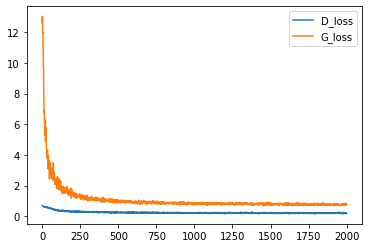

In [20]:
plt.plot(D_loss_list, label='D_loss')
plt.plot(G_loss_list, label='G_loss')
plt.legend()
plt.show()

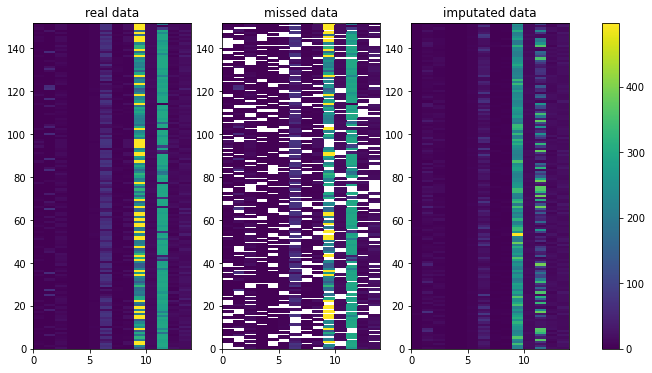

In [22]:
test_data_x, miss_test_data_x, test_data_m = data_loader(test_data, miss_rate=0.3)

test_data_x = torch.from_numpy(test_data_x).float()
miss_test_data_x0 = torch.from_numpy(np.nan_to_num(miss_test_data_x, nan=0.0, copy=True)).float()
test_data_m = torch.from_numpy(test_data_m).float()

z = sample_z(cols, test_data_x.shape[0])
input_fake = torch.cat([z, test_data_m], axis=1)
data_fake = G(input_fake)


f, axs = plt.subplots(1,3, figsize=(12,6))
axs[0].pcolormesh(scaler.inverse_transform(test_data_x))
axs[0].set_title("real data")
axs[1].pcolormesh(scaler.inverse_transform(miss_test_data_x))
axs[1].set_title("missed data")
im = axs[2].pcolormesh(scaler.inverse_transform(data_fake.cpu().detach()))
axs[2].set_title("imputated data")

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()